# About

A sketch of the [machine translation tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) from the [PyTorch Tutorials](https://pytorch.org/tutorials/index.html).

It's the closest analogy to automated document conversion, so this is an attempt to study its internals.

## Model

This is a sequence-to-sequence (seq2seq) model, consisting of a pair of [recurrent neural networks (RNN)](https://en.wikipedia.org/wiki/Recurrent_neural_network), the encoder and decoder. 

The encoder reads an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence.

![diagram](images/seq2seq.png)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Encoder

This is the first half of the RNN seq2seq network, aka [Encoder Decoder network](https://arxiv.org/pdf/1406.1078v3.pdf).

For every input (word token, in this example) the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

![encoder](images/encoder-network.png)

In [3]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        # using a multi-layer gated recurrent unit (GRU) 
        # as an improvement over long short-term memory (LSTM) 
        self.gru = nn.GRU(hidden_size, hidden_size)
        
    def forward(self, input_layer, hidden_layer):
        embedded = self.embedding(input_layer).view(1, 1, -1)
        output_layer, hidden_layer = self.gru(embedded, hidden_layer)
        return output_layer, hidden_layer
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Decoder

The is the second half of the model, another RNN that takes the encoder's output vectors as its input, and outputs a sequence of words to create the translation:

![decoder](images/decoder-network.png)

In [4]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_layer, hidden_layer):
        output_layer = F.relu(self.embedding(input).view(1, 1, -1))
        output_layer, hidden_layer = self.gru(output_layer, hidden_layer)
        output_layer = self.softmax(self.out(output_layer[0]))
        return output_layer, hidden_layer
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Attention Decoder

Without this, the context vector which is passed betweeen the encoder and decoder carries the burden of encoding the entire sentence.

The attention RNN allows the decoder network to "focus" on a different part of the encoder's outputs for every step of the decoder's own outputs.

![diagram](images/attention-decoder.png)

Calculating the attention weights is done with another feed-forward layer, `attn`, using the decoder's input and hidden state as inputs.

Rather than using [bucketing](https://www.kaggle.com/bminixhofer/speed-up-your-rnn-with-sequence-bucketing) for handling inputs of variable length in the training data, this example chooses a maximum sentence length that gets applied to all inputs: sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few.

![diagram](images/attention-decoder-network.png)

In [5]:
class AttentionDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout, max_length):
        super(AttentionDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.max_length = max_length
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attention = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attention_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input_layer, hidden_layer, encoder_output):
        embedded = self.dropout(self.embedding(input_layer).view(1, 1, -1))
        attention_weights = F.softmax(self.attention(torch.cat((embedded[0], hidden_layer[0]), 1)), dim=1)
        attention_applied = torch.bmm(attention_weights.unsqueeze(0), encoder_output.unsqueeze(0))
        output_layer = self.attention_combine(torch.cat((embedded[0], attention_applied[0]), 1)).unsqueeze(0)
        output_layer, hidden_layer = self.gru(F.relu(output_layer), hidden_layer)
        output_layer = F.log_softmax(self.out(output_layer[0]), dim=1)
        return output_layer, hidden_layer, attention_weights
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Training Functions

In [6]:
# helper functions

import time
import math

def in_minutes(seconds):
    minutes = math.floor(seconds / 60)
    seconds -= minutes * 60
    return '%dm %ds' % (minutes, seconds)

def since(prior, percent):
    seconds = time.time() - prior
    gap = (seconds / percent) - seconds
    return '%s (- %s)' % (in_minutes(seconds), in_minutes(gap))

In [7]:
import random

teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, enc_optimizer, dec_optimizer, crit, max_len):
    encoder_hidden = encoder.init_hidden()
    enc_optimizer.zero_grad()
    dec_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_len, encoder.hidden_size, device=device)
    loss = 0
    
    for i in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[i], encoder_hidden)
        encoder_outputs[i] = encoder_output[0, 0]
    
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    for i in range(target_length):
        if random.random() < teacher_forcing_ratio:
            # Teacher forcing: Feed the target as the next input
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            
            loss += crit(decoder_output, target_tensor[i])
            decoder_input = target_tensor[i]
        else:
            # Without teacher forcing: use its own predictions as the next input
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()
            
            loss += crit(decoder_output, target_tensor[i])
            if decoder_input.item() == EOS_token:
                break
                
    loss.backward()
    enc_optimizer.step()
    dec_optimizer.step()
    
    return loss.item() / target_length

In [8]:
# for plotting results
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

%matplotlib inline

def show_plot(data):
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(data)

In [9]:
def train_tensors(encoder, decoder, training_tensors, max_len, print_every, plot_every, learning_rate):
    start = time.time()
    losses = []
    print_loss_total = 0
    plot_loss_total = 0
    
    enc_optimizer = torch.optim.SGD(encoder.parameters(), lr=learning_rate)
    dec_optimizer = torch.optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    
    iterations = len(training_tensors)
    for i in range(1, iterations+1):
        training_pair = training_tensors[i-1]
        input_tensor  = training_pair[0]
        target_tensor = training_pair[1]
        
        loss = train(input_tensor, target_tensor, encoder, decoder, enc_optimizer, dec_optimizer, criterion, max_len)
        print_loss_total += loss
        plot_loss_total += loss
        
        if i % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (since(start, i/iterations), i, i/iterations * 100, print_loss_avg))
            
        if i % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    print('Preparing plot: %d losses (data points)' % len(losses))
    show_plot(losses)

## Putting it all together

Using the tab-delimited examples from [Anki](https://www.manythings.org/anki/) to see if it's possible to produce a simple English to Japanese translation service.

### Sidebar: parsing Japanese text in python

This proved to be surprisingly complicated. 

[KyTea](http://www.phontron.com/kytea/) would not install until going down to version `0.3.2`, and even then would not run properly.

[This guide](images/japanese-spacy-and-mecab.pdf) (archived from the [original](https://www.dampfkraft.com/nlp/japanese-spacy-and-mecab.html)) was helpful, but I needed a few more tweaks to make it work:

* `sudo ldconfig` gets around the `error while loading shared libraries: libmecab.so.2` building `unidic-mecab-2.1.2_src` (hat tip to [tatsuyaoiw](http://tatsuyaoiw.hatenablog.com/entry/20120414/1334397985))
* edited `/usr/local/etc/mecabrc` so that `dicdir` is defined as `dicdir = /usr/local/lib/mecab/dic/unidic`
* after `pip install mecab-python3==0.7` and `pip install spacy` I also needed `pip install fugashi`

In [10]:
!if [ ! -f ./data/jpn-eng.zip ]; then wget -P ./data https://www.manythings.org/anki/jpn-eng.zip; fi

In [11]:
!if [ ! -f ./data/jpn.txt ]; then unzip -d ./data ./data/jpn-eng.zip; fi

In [12]:
from pathlib import Path
data_file = Path.cwd() / "data/jpn.txt"

In [13]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name, parser):
        self.name = name
        self.parser = parser
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS"}
        self.n_words = 2
        
    def add_sentence(self, sentence):
        for word in self.parser(sentence):
            self.add_word(word)
            
    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
    def indices_from_sentence(self, sentence):
        return [self.word2index[word] for word in self.parser(sentence)]

In [14]:
"""
Define the Japanese language parser
"""

import spacy
ja = spacy.blank('ja')

def parse_japanese(sentence):
    return [word.text for word in ja(sentence)]

"""
English can be more complicated than this, 
but this suffices for this simple model
"""

def parse_english(sentence):
    return sentence.split(' ')

In [15]:
def parse_language_pairs(input_file=data_file):
    pairs = [] # list of (eng, jpn) pairs
    for line in data_file.read_text(encoding='utf-8').splitlines():
        parts = line.split('\t')
        if len(parts) > 1:
            pairs.append((parts[0].strip(), parts[1].strip()))
    return pairs

In [16]:
MAX_WORD_LENGTH = 20

def filter_by_word_length(pair):
    """
    Since the AttentionDecoderRNN is based on a max_length,
    this function provides a filter based on that parameter 
    """
    return len(pair) == 2 \
      and len(parse_english(pair[0])) < MAX_WORD_LENGTH \
      and len(parse_japanese(pair[1])) < MAX_WORD_LENGTH

In [17]:
samples = [pair for pair in parse_language_pairs() if filter_by_word_length(pair)]

In [18]:
def prepare_sample(parsed_pairs):
    """
    Given a list of (eng, jpn) pairs, produce 
    a tuple (Lang(eng), Lang(jpn)) of the data
    """
    eng = Lang('eng', parse_english)
    jpn = Lang('jpn', parse_japanese)
    for pair in parsed_pairs:
        eng.add_sentence(pair[0])
        jpn.add_sentence(pair[1])
    return eng, jpn

In [19]:
eng, jpn = prepare_sample(samples)
len(samples), eng.n_words, jpn.n_words

(47612, 16361, 13291)

## Converting training data to [tensors](https://pytorch.org/docs/stable/tensors.html)

In [20]:
def generate_tensor(lang, sentence):
    indicies = lang.indices_from_sentence(sentence)
    indicies.append(EOS_token)
    return torch.tensor(indicies, dtype=torch.long, device=device).view(-1, 1)

In [21]:
training_tensors = [
    (generate_tensor(eng, pair[0]), 
     generate_tensor(jpn, pair[1])) 
    for pair in samples
]    

## Train the model

In [22]:
import pickle
encoder_file = Path.cwd() / "data/encoder.pkl"
decoder_file = Path.cwd() / "data/decoder.pkl"

7m 30s (- 171m 21s) (2000 4%) 4.1404
16m 28s (- 179m 41s) (4000 8%) 3.7958
26m 11s (- 181m 39s) (6000 12%) 3.5731
36m 23s (- 180m 9s) (8000 16%) 3.5235
46m 57s (- 176m 35s) (10000 21%) 3.5602
58m 0s (- 172m 8s) (12000 25%) 3.5699
69m 38s (- 167m 12s) (14000 29%) 3.5354
79m 56s (- 157m 56s) (16000 33%) 3.5719
87m 17s (- 143m 36s) (18000 37%) 3.5440
94m 50s (- 130m 55s) (20000 42%) 3.7074
102m 38s (- 119m 29s) (22000 46%) 3.6637
110m 35s (- 108m 48s) (24000 50%) 3.6851
118m 45s (- 98m 43s) (26000 54%) 3.7732
127m 8s (- 89m 3s) (28000 58%) 3.7161
135m 36s (- 79m 36s) (30000 63%) 3.7713
144m 20s (- 70m 25s) (32000 67%) 3.8579
153m 15s (- 61m 21s) (34000 71%) 3.9100
162m 28s (- 52m 24s) (36000 75%) 3.9732
172m 5s (- 43m 31s) (38000 79%) 3.9219
181m 54s (- 34m 36s) (40000 84%) 4.1058
192m 7s (- 25m 40s) (42000 88%) 4.1527
210m 10s (- 17m 15s) (44000 92%) 4.2791
230m 16s (- 8m 4s) (46000 96%) 4.3954
Preparing plot: 47 losses (data points)


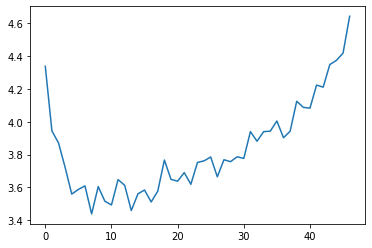

In [23]:
hidden_size = 256

if encoder_file.exists() and decoder_file.exists():
    encoder = pickle.load(open(encoder_file, 'rb'))
    attn_decoder = pickle.load(open(decoder_file, 'rb'))
else:
    encoder = EncoderRNN(eng.n_words, hidden_size).to(device)
    attn_decoder = AttentionDecoderRNN(hidden_size, jpn.n_words, 0.1, MAX_WORD_LENGTH).to(device)
    train_tensors(encoder, attn_decoder, training_tensors, MAX_WORD_LENGTH, 2000, 1000, 0.02)
    pickle.dump(encoder, open(encoder_file, 'wb'))
    pickle.dump(attn_decoder, open(decoder_file, 'wb'))

## Evaluate the results

In [24]:
def evaluate(encoder, decoder, input_tensor, output_lang, max_length=MAX_WORD_LENGTH):
    with torch.no_grad():
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.init_hidden()
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        for i in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[i], encoder_hidden)
            encoder_outputs[i] += encoder_output[0, 0]
            
        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden
        
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        
        for i in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[i] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()
            
        return decoded_words, decoder_attentions[:i + 1]

In [25]:
def evaluate_pair(encoder, decoder, pair, input_lang, output_lang):
    print('>', pair[0])
    print('=', pair[1])
    output_words, attentions = evaluate(encoder, decoder,  generate_tensor(input_lang, pair[0]), output_lang)
    output_sentence = u''.join(output_words)
    print('<', output_sentence)
    print('')

In [26]:
# sample some random entries
for i in range(30):
    pair = random.choice(samples)
    evaluate_pair(encoder, attn_decoder, pair, eng, jpn)

> Everything will be fine.
= 全部うまくいくよ。
< 今日のはのはのののにのててててている。<EOS>

> What he said turned out to be true.
= 彼が言ったことは本当だとわかった。
< 彼はにとととととととととととととた。<EOS>

> I am a member of the basketball team.
= ボクは、そのバスケットボールチームのメンバーだよ。
< 私ののののののののをた。<EOS>

> I have two brothers.
= 私には２人兄弟がいます。
< ２の２のののしていていた。<EOS>

> Call me once you've arrived.
= 着いたら電話してね。
< 最近ののののののをををを。<EOS>

> I had to walk because there were no taxis.
= タクシーがいなかったので歩かなければいけなかった。
< 昨日にににになかっなかった。<EOS>

> He was condemned to death.
= 彼は死刑を宣告された。
< 彼は今ををににたた。<EOS>

> I had no choice but to accept the offer.
= その申し出を受け入れる他に選択肢がなかった。
< 私はそのにににににににない。<EOS>

> I don't want to talk to you.
= あなたと話したくありません。
< 話したくない人の話したくないと、話したくないと、ない。<EOS>

> Please let me drive your new Toyota, too.
= 君の新しいトヨタ、僕にも運転させて。
< 新しいを新しいををお願いをお願いをください。<EOS>

> Mother Teresa was born in Yugoslavia in 1910.
= マザー・テレサは１９１０年にユーゴスラビアで生まれた。
< 昨日のでととととたた。<EOS>

> Tom thinks volleyball is more fun than basketball.
= トムはバスケよりバレーの方が面白いと思っている。
< トムはもっとよりより、より、より、をををををいる